### Note: We're not treating a seperate validation split, this is due to the fact that we're not hypertuning any of the below mentioned DL architecture. 
### Apart from this the below used architectures generate a randomly selected test dataset on each iteration, hence already provides us with a deep insight into performance of the model.


In [ ]:
!pip install scikit-plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baseline DL model

### import the libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Yinky_DL_FINAL__9521/data/test.csv")
df.head()

,Unnamed: 0,preprocessed2,Classification
0,0,uas while during departure from westhampton be...,Minimal
1,1,uas 100 foot below acft while 1 w apch end run...,Catastrophic
2,2,uas 12 o clock 500 foot below acft 8 s centenn...,Hazardous
3,3,overfly uas 6 000 foot 3 s prescott arpt uas f...,Minor
4,4,uas from 3 o clock 3 mile final runway 32 no e...,Minor


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3132 non-null   int64 
 1   preprocessed2   3132 non-null   object
 2   Classification  3132 non-null   object
dtypes: int64(1), object(2)
memory usage: 73.5+ KB


### In the original dataset there're two classes "minor" and "minor ", the latter needs to be corrected in order to avoid evaluation of an extra class.

In [ ]:
df["Classification"] = df.Classification.apply(lambda x: x.strip())

In [ ]:
df['preprocessed2'][0]

'uas while during departure from westhampton beach no evasive action take west hampton beach'

In [ ]:
df.Classification.value_counts()

Minimal         1026
Minor            869
Hazardous        827
Catastrophic     410
Name: Classification, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3132 non-null   int64 
 1   preprocessed2   3132 non-null   object
 2   Classification  3132 non-null   object
dtypes: int64(1), object(2)
memory usage: 73.5+ KB


### Description of some of the terminologies below:
  1. vocab_size: represents the maximum number of words we're gonna be taking into account when being ranked in decreasing frequency of each.
  2. batch_size: This represents the number of data points that'll be passed into the neural network layer at once, if not initiated this will in turn take too much of time.
  3. num_epocs: represents the number of epochs, which simply means the times we want the data to iterate through the entire dataset.
  4. encoder: The encoder basically encodes the string values of the label feature to one hot representation.
  5. tokenizer : tokenizer is responsible to covert the string input values to numric values to numeric representations, herein we're using tfidf mode.

(2505,) (2505,)
(314,) (314,)
(313,) (313,)


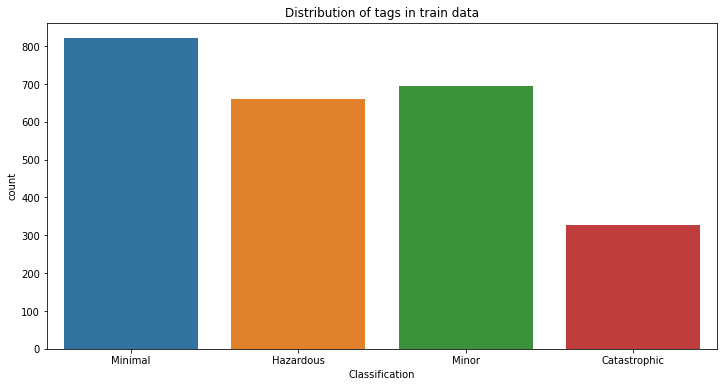

In [ ]:
vocab_size = 15000
batch_size = 100
num_epochs = 30

#train_size = int(len(df) * .8)

# train_posts = df["preprocessed2"][:train_size]
# train_tags = df["Classification"][:train_size]

# test_posts = df["preprocessed2"][train_size:]
# test_tags = df["Classification"][train_size:]

X = df["preprocessed2"]
Y = df["Classification"]

# lets take 80% data as training and remaining 20% for test.
train_posts, test_posts, train_tags, test_tags = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify=Y)
# Added code
test_posts, val_posts, test_tags, val_tags = train_test_split(test_posts, test_tags, test_size = 0.5, random_state = 42,stratify=test_tags)

print(train_posts.shape,train_tags.shape)
print(val_posts.shape, val_tags.shape)
print(test_posts.shape,test_tags.shape)

# Count plot for train_tags
plt.figure(figsize=(12,6))
sns.countplot(train_tags)
plt.title('Distribution of tags in train data')
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_val = tokenizer.texts_to_matrix(val_posts, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
# Added code
y_val = encoder.transform(val_tags)
y_test = encoder.transform(test_tags)

Here in above plot, the majority class is Minimal, & the minority class is Catastrophic. We can see that the train data is imbalanced i.e., all classes are not distributed uniformly.

We're using the keras sequential API here.

Being a baseline model I'm using ANN that is artificial neural network here, to initiate that we use Dense layer from keras.
Since the labels to be predicted is 4, we're using softmax activation function at last layer to output the probability of each class predictions.

And hence printing the model architecture.


In [ ]:
num_labels = 4
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.6))       # Dropout rate tried - 0.3, 0.5, 0.4, 0.6
model.add(Dense(128))         # number of units tried- 500, 256, 128
model.add(Activation('relu'))
model.add(Dropout(0.6))       # Dropout rate tried - 0.3, 0.5, 0.6
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4), # Learning rate tried - 1e-5, 1e-6, 1e-3, 1e-4
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7680512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5

Training the model,
the model below is slightly overfitted, but it can always be tweaked by just reducing the number of epochs.

In [ ]:
num_epochs =40            # tried - 10, 100, 20, 40
batch_size = 256          # tried 128, 64, 32, 8, 256
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    # verbose=2,
                    # Added parameter
                    validation_data = (x_val, y_val))


Epoch 1/40
10/10 [==============================] - 3s 46ms/step - loss: 1.3954 - accuracy: 0.3026 - val_loss: 1.3553 - val_accuracy: 0.3599
Epoch 2/40
10/10 [==============================] - 0s 24ms/step - loss: 1.3624 - accuracy: 0.3273 - val_loss: 1.3329 - val_accuracy: 0.3949
Epoch 3/40
10/10 [==============================] - 0s 23ms/step - loss: 1.3454 - accuracy: 0.3497 - val_loss: 1.3129 - val_accuracy: 0.4490
Epoch 4/40
10/10 [==============================] - 0s 23ms/step - loss: 1.3200 - accuracy: 0.3760 - val_loss: 1.2941 - val_accuracy: 0.5032
Epoch 5/40
10/10 [==============================] - 0s 22ms/step - loss: 1.2751 - accuracy: 0.4411 - val_loss: 1.2743 - val_accuracy: 0.5318
Epoch 6/40
10/10 [==============================] - 0s 21ms/step - loss: 1.2639 - accuracy: 0.4579 - val_loss: 1.2522 - val_accuracy: 0.5764
Epoch 7/40
10/10 [==============================] - 0s 22ms/step - loss: 1.2329 - accuracy: 0.4890 - val_loss: 1.2278 - val_accuracy: 0.6019
Epoch 8/40
10

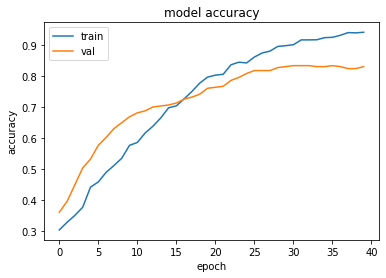

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

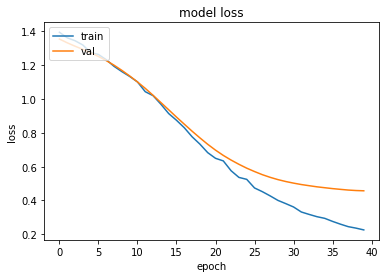

In [ ]:
# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

generating the predictions on the test set

In [ ]:
x_t = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

y_pred = model.predict_on_batch(x_t)
# y_pred

generating the confusion matrix

In [ ]:
from sklearn import metrics

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
# matrix

In [ ]:
encoder.classes_

array(['Catastrophic', 'Hazardous', 'Minimal', 'Minor'], dtype='<U12')

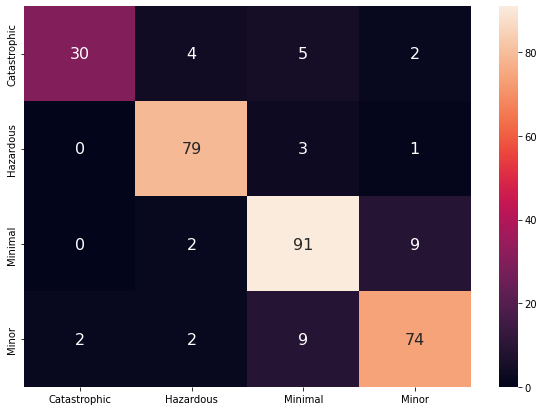

In [ ]:
# Plot Confusion matrix
l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

30 Catastrophic labels were predicted correctly, while 4 were predicted as Hazardous, 5 as Minimal and 2 as Minor.

79 Hazardous labels were predicted correctly, while 0 were predicted as Catastrophic,3 as Minimal and 1 as Minor.

91 Minimal labels were predicted correctly, while 0 were predicted as Catastrophic,2 as Hazardous and 9 as Minor.

74 Minor labels were predicted correctly, while 2 were predicted as Catastrophic, 2 as Hazardous and 9 as Minimal.


generating the classification report

In [ ]:
classReport = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.94      0.73      0.82        41
   Hazardous       0.91      0.95      0.93        83
     Minimal       0.84      0.89      0.87       102
       Minor       0.86      0.85      0.86        87

    accuracy                           0.88       313
   macro avg       0.89      0.86      0.87       313
weighted avg       0.88      0.88      0.87       313



### ROC curve

ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better will be the model is at distinguishing classes. ROC curve usually used as metric for imbalanced classification problems. Since the classes in our data are imbalanced, we are using ROC curve.    

The ROC curve is plotted with TPR (True Positive Rate) against the FPR(False Positive Rate) where TPR is on the y-axis and FPR is on the x-axis.

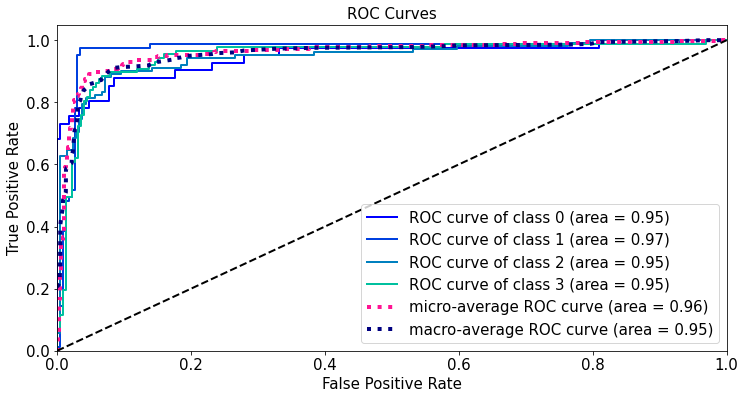

In [ ]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above ROC curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor

### Precision-Recall curve

Precision-Recall curve is the plot between precision & recall. Area under precision & recall curve is high means the model performing well. This is also good metric for imbalanced classification problems.

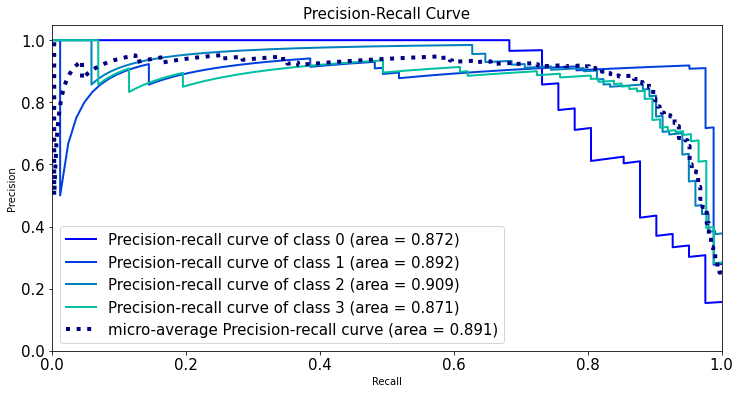

In [ ]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above Precision-Recall curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor 

# Tweaked Deeplearning

The same workflow as above follows, with just some tweakings like

introducing an Embedding layer, an LSTM layer and changing some hyperparameters.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Yinky_DL_FINAL__9521/data/test.csv')
print(data.shape)

(3132, 3)


In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['preprocessed2'].values)
X = tokenizer.texts_to_sequences(data['preprocessed2'].values)
X = pad_sequences(X)

In [ ]:
embed_dim = 128
lstm_out = 128                # lstm_out tried - 196, 128

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))                 
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))  # dropout rates tried - 0.2, 0.4     recurrent_dropout rates tried - 0.2, 0.4
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 46, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 46, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 388,100
Trainable params: 388,100
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Y = pd.get_dummies(data['Classification']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify=Y)
# Added code
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size = 0.5, random_state = 42,stratify=Y_test)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(2505, 46) (2505, 4)
(314, 46) (314, 4)
(313, 46) (313, 4)


In [ ]:
del data, Y, X

In [ ]:
# adding the explaination for VS

In [ ]:
batch_size = 256     # Tried - 32, 64, 128
# Added validation_data parameter
history = model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, validation_data=(X_val, Y_val))  # Epochs tried - 5, 7 , 10

Epoch 1/20
10/10 [==============================] - 7s 400ms/step - loss: 1.3567 - accuracy: 0.3281 - val_loss: 1.3245 - val_accuracy: 0.3280
Epoch 2/20
10/10 [==============================] - 4s 352ms/step - loss: 1.3197 - accuracy: 0.3800 - val_loss: 1.3001 - val_accuracy: 0.3631
Epoch 3/20
10/10 [==============================] - 3s 343ms/step - loss: 1.2466 - accuracy: 0.4040 - val_loss: 1.1530 - val_accuracy: 0.4873
Epoch 4/20
10/10 [==============================] - 3s 345ms/step - loss: 1.0689 - accuracy: 0.5134 - val_loss: 0.9214 - val_accuracy: 0.5955
Epoch 5/20
10/10 [==============================] - 3s 347ms/step - loss: 0.8772 - accuracy: 0.5996 - val_loss: 0.7976 - val_accuracy: 0.5796
Epoch 6/20
10/10 [==============================] - 3s 342ms/step - loss: 0.7923 - accuracy: 0.6475 - val_loss: 0.7485 - val_accuracy: 0.5924
Epoch 7/20
10/10 [==============================] - 3s 345ms/step - loss: 0.7135 - accuracy: 0.6830 - val_loss: 0.6857 - val_accuracy: 0.6943
Epoch 

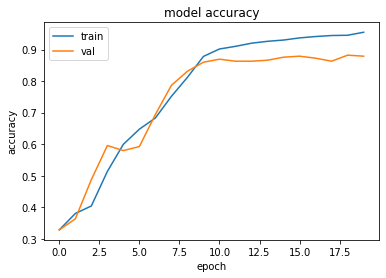

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

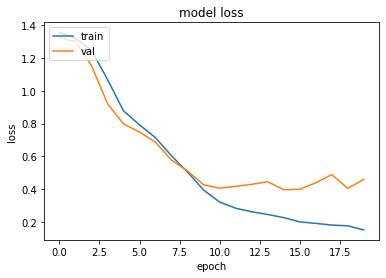

In [ ]:
# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Get predictions
y_pred = model.predict_on_batch(X_test)
y_pred

array([[1.0731877e-03, 2.8623757e-03, 9.0170968e-01, 9.4354734e-02],
       [7.3294272e-05, 1.9461625e-04, 9.9913293e-01, 5.9918308e-04],
       [1.1505663e-04, 4.2231896e-04, 9.9879187e-01, 6.7083049e-04],
       ...,
       [8.8515459e-04, 1.9538361e-03, 9.8638982e-01, 1.0771143e-02],
       [5.7137497e-03, 7.8724716e-03, 6.2519532e-01, 3.6121845e-01],
       [7.4761719e-03, 5.6022342e-02, 6.7058617e-01, 2.6591533e-01]],
      dtype=float32)

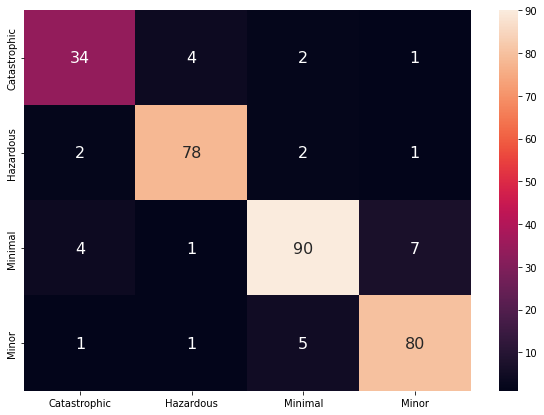

In [ ]:
# Plot confusin matrix
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

34 Catastrophic labels were predicted correctly, while 4 were predicted as Hazardous, 2 as Minimal and 1 as Minor.

78 Hazardous labels were predicted correctly, while 2 were predicted as Catastrophic, 2 as Minimal and 1 as Minor.

90 Minimal labels were predicted correctly, while 4 were predicted as Catastrophic,1 as Hazardous and 7 as Minor.

80 Minor labels were predicted correctly, while 1 were predicted as Catastrophic,1 as Hazardous and 5 as Minimal.


In [ ]:
classReport = metrics.classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.83      0.83      0.83        41
   Hazardous       0.93      0.94      0.93        83
     Minimal       0.91      0.88      0.90       102
       Minor       0.90      0.92      0.91        87

    accuracy                           0.90       313
   macro avg       0.89      0.89      0.89       313
weighted avg       0.90      0.90      0.90       313



### ROC curve

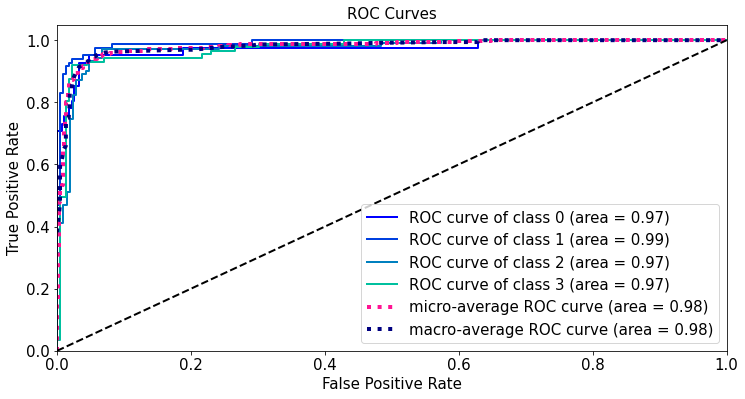

In [ ]:
skplt.metrics.plot_roc(Y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above ROC curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor

### Precision-Recall curve

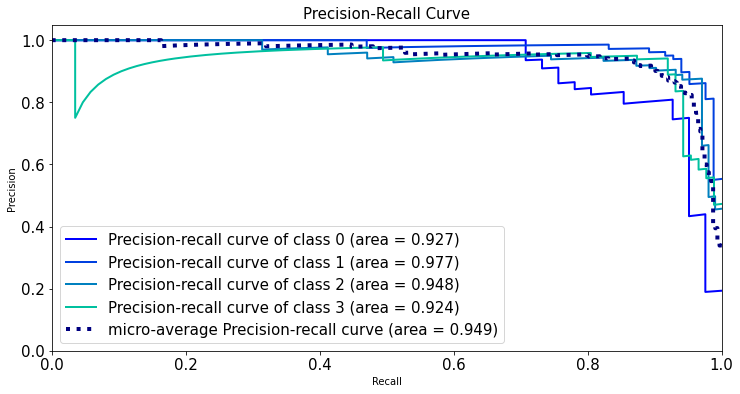

In [ ]:
skplt.metrics.plot_precision_recall_curve(Y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above Precision-Recall curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor 

# Using BERT

### kindly make sure to execute the cell below before running the code for bert

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 33.6 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 48.0 MB/s 
     |████████████████████████████████| 3.3 MB 50.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


some imports and preprocessing

In [ ]:
# parameters of bert: batch_size = 3, epochs = 10, learning rate=1e-5


In [ ]:
import torch
from tqdm.notebook import tqdm
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Yinky_DL_FINAL__9521/data/test.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3132 non-null   int64 
 1   preprocessed2   3132 non-null   object
 2   Classification  3132 non-null   object
dtypes: int64(1), object(2)
memory usage: 73.5+ KB


In [ ]:
df['Classification'].value_counts()

Minimal         1026
Minor            869
Hazardous        827
Catastrophic     410
Name: Classification, dtype: int64

In [ ]:
possible_labels = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Catastrophic': 0, 'Hazardous': 1, 'Minimal': 2, 'Minor': 3}

In [ ]:
df['label'] = df.Classification.replace(label_dict)

In [ ]:
df.head(1)

,Unnamed: 0,preprocessed2,Classification,label
0,0,uas while during departure from westhampton be...,Minimal,2


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=df.label.values)
# Added code
X_test, X_val, y_test, y_val = train_test_split(X_test, 
                                                  y_test, 
                                                  test_size=0.5, 
                                                  random_state=42, 
                                                  stratify=y_test)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [ ]:
df.groupby(['Classification', 'label', 'data_type']).count()

Unnamed: 0  preprocessed2
Classification label data_type                           
Catastrophic   0     test               41             41
                     train             328            328
                     val                41             41
Hazardous      1     test               83             83
                     train             661            661
                     val                83             83
Minimal        2     test              102            102
                     train             821            821
                     val               103            103
Minor          3     test               87             87
                     train             695            695
                     val                87             87

initialization of the BERT tokenizer, with vocab of lower cased words

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df.head()

,Unnamed: 0,preprocessed2,Classification,label,data_type
0,0,uas while during departure from westhampton be...,Minimal,2,train
1,1,uas 100 foot below acft while 1 w apch end run...,Catastrophic,0,train
2,2,uas 12 o clock 500 foot below acft 8 s centenn...,Hazardous,1,train
3,3,overfly uas 6 000 foot 3 s prescott arpt uas f...,Minor,3,train
4,4,uas from 3 o clock 3 mile final runway 32 no e...,Minor,3,train


encoding the input text as per the BERT requirements, this aslo generates attention masks and padded input variant of the layer correspondingly.

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].preprocessed2.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True,
    truncation=True, 
    max_length=150,           # max_length tried - 256, 100, 150
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].preprocessed2.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True,
    truncation=True,
    max_length=150,       # max_length tried - 256, 100
    return_tensors='pt'
)

# Added code
encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].preprocessed2.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True,
    truncation=True,
    max_length=150,       # max_length tried - 256, 100
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

# Added code
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)

converting the encoded values to tensors so could be passed into BERT architecture.

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
# Added code
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
len(dataset_train), len(dataset_val), len(dataset_test)

(2505, 314, 313)

Initialization of the BERT Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

This cell converts the above obtained to tensors to pytorch datasets

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16       # Batch size tried  - 3, 16, 32, 64

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)  
# Added code 
dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

initialization of ADAM optimizer

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-4,                      # lr tried - 1e-5, 1e-4, 1e-3
                  eps=1e-8)

In [ ]:
epochs = 10             # Epochs tried - 5, 10, 7

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

Making functions for metrics later to be used in training the model.

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    totalCorrect = 0
    total = 0
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        totalCorrect += len(y_preds[y_preds==label])
        total += len(y_true)

    return {"accuracy":float(totalCorrect/total)}

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

setting seeds to avoid different results in different executions

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


The evaluate function helps in evaluating the model performance by providing the loss values, true y values and predicted y values

In [ ]:
def evaluate(dataloader):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

training the BERT model and saving the each configuration after each respective epoch

In [ ]:

# Store the average loss & accuracy after each epoch so we can plot them.
train_loss, train_acc = [], []
validation_loss , validation_acc = [], []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    acc_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()

        # train predictions
        preds = outputs[1] 

        # Move logits and labels to CPU
        preds = preds.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()

        # Calculate the accuracy for this batch.
        tmp_train_accuracy = flat_accuracy(preds, label_ids)
        # Accumulate the total accuracy.
        acc_train_total += tmp_train_accuracy

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        progress_bar.set_postfix({'training_acc': '{:.3f}'.format(tmp_train_accuracy/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Yinky_DL_FINAL__9521/models/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    acc_train_avg = acc_train_total/len(dataloader_train)

    # Append training loss & accuracy for each epoch
    train_acc.append(acc_train_avg)
    train_loss.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {acc_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    # Calculate validation accuracy
    val_acc = flat_accuracy(predictions, true_vals)
    val_f1 = f1_score_func(predictions, true_vals)
    # Append Validation loss & accuracy for each epoch
    validation_acc.append(val_acc)
    validation_loss.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6950058882498438
Training accuracy: 0.7445152158527955
Validation loss: 0.31482486687600614
Validation accuracy: 0.9267515923566879
F1 Score (Weighted): 0.9262760385763562


Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4476367733708233
Training accuracy: 0.8873407643312102
Validation loss: 0.3346252113580704
Validation accuracy: 0.9267515923566879
F1 Score (Weighted): 0.9269707620993651


Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3681277740556913
Training accuracy: 0.910828025477707
Validation loss: 0.2738862960599363
Validation accuracy: 0.945859872611465
F1 Score (Weighted): 0.9456750301887007


Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.30909048523872523
Training accuracy: 0.9267515923566879
Validation loss: 0.18683467591181396
Validation accuracy: 0.9554140127388535
F1 Score (Weighted): 0.955225816698827


Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2492762544625409
Training accuracy: 0.9410828025477707
Validation loss: 0.17210246324539186
Validation accuracy: 0.9585987261146497
F1 Score (Weighted): 0.9586786797106116


Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.2087950995666491
Training accuracy: 0.9475406935598019
Validation loss: 0.13699316685087978
Validation accuracy: 0.964968152866242
F1 Score (Weighted): 0.9648637049022177


Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.188719148071376
Training accuracy: 0.9551043878273178
Validation loss: 0.16866741674020885
Validation accuracy: 0.9617834394904459
F1 Score (Weighted): 0.9615136419945128


Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.15401546575520544
Training accuracy: 0.9633757961783439
Validation loss: 0.18674240584950894
Validation accuracy: 0.9585987261146497
F1 Score (Weighted): 0.9586298454811572


Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.11416412237141828
Training accuracy: 0.9741242038216561
Validation loss: 0.16443241962697358
Validation accuracy: 0.964968152866242
F1 Score (Weighted): 0.9650102943550124


Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.08065594242482334
Training accuracy: 0.9804936305732485
Validation loss: 0.18183162237983197
Validation accuracy: 0.9585987261146497
F1 Score (Weighted): 0.9587242481001221


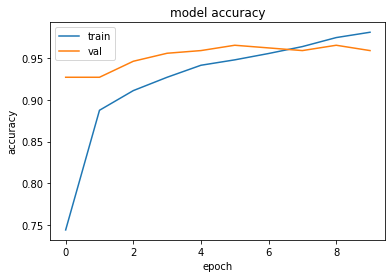

In [ ]:
# Plot accuracy curve
plt.plot(train_acc)
plt.plot(validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

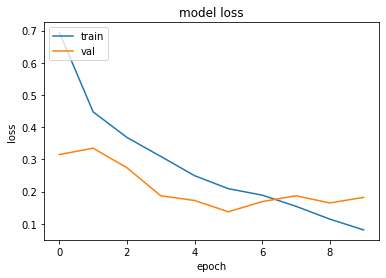

In [ ]:
# Plot loss curve
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

initializing the "model" again

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

using the weights generated during training and load them into the above initialised model.

In [ ]:
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Yinky_DL_FINAL__9521/models/finetuned_BERT_epoch_{epochs}.model', map_location=torch.device('cpu')))

<All keys matched successfully>

generating predictions

In [ ]:
_, predictions, true_test = evaluate(dataloader_test)

In [ ]:
accuracy_per_class(predictions, true_test)

Class: Catastrophic
Accuracy: 38/41

Class: Hazardous
Accuracy: 80/83

Class: Minimal
Accuracy: 98/102

Class: Minor
Accuracy: 83/87



{'accuracy': 0.9552715654952076}

### Making the confusion matrix and the classification report.

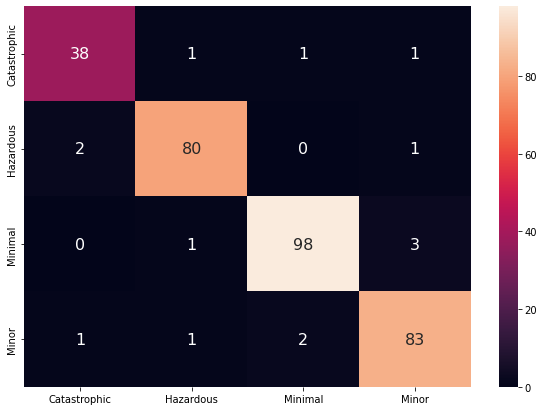

In [ ]:
matrix = metrics.confusion_matrix(true_test, predictions.argmax(axis=1))
l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in l],
                  columns = [i for i in l])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

38 Catastrophic labels were predicted correctly, while 1 were predicted as Hazardous,1 as Minimal and 1 as Minor.

80 Hazardous labels were predicted correctly, while 2 were predicted as Catastrophic,0 as Minimal and 1 as Minor.

98 Minimal labels were predicted correctly, while 0 were predicted as Catastrophic,1 as Hazardous and 3 as Minor.

83 Minor labels were predicted correctly, while 1 were predicted as Catastrophic, 1 as Hazardous and 2 as Minimal.


In [ ]:
classReport = metrics.classification_report(true_test, predictions.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.93      0.93      0.93        41
   Hazardous       0.96      0.96      0.96        83
     Minimal       0.97      0.96      0.97       102
       Minor       0.94      0.95      0.95        87

    accuracy                           0.96       313
   macro avg       0.95      0.95      0.95       313
weighted avg       0.96      0.96      0.96       313



### ROC curve

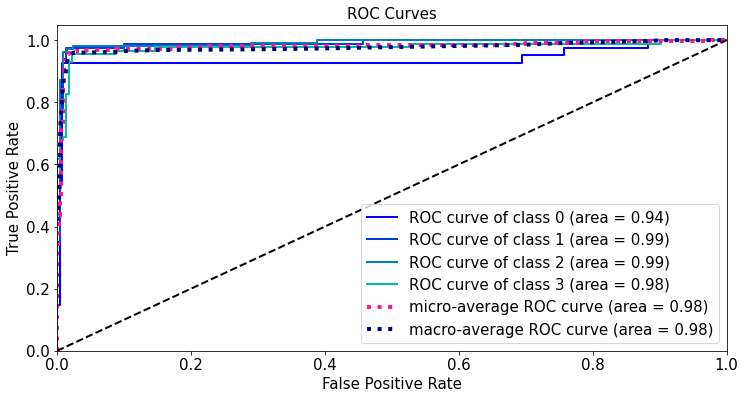

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_roc(true_test, predictions, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In ROC plot,  
class 0 - Catastrophic,       
class 1 - Hazardous,      
class 2 - Minimal,    
class 3 - Minor 

### Precision-Recall curve

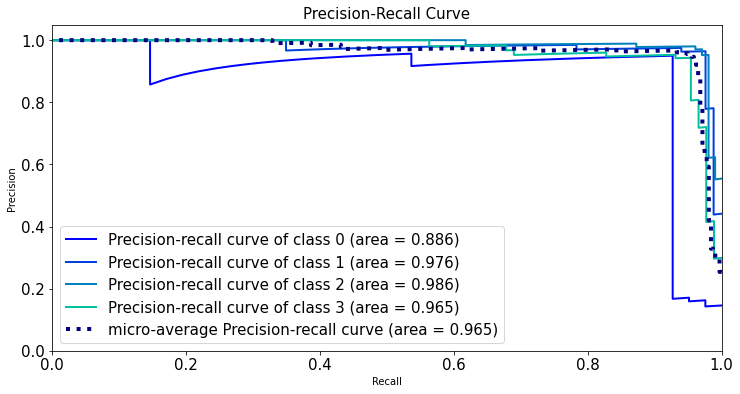

In [ ]:
skplt.metrics.plot_precision_recall_curve(true_test, predictions, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above precision-recall curve,      
class 0 - Catastrophic,       
class 1 - Hazardous,      
class 2 - Minimal,    
class 3 - Minor

# Bidirectional LSTM

In [ ]:
# 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Yinky_DL_FINAL__9521/data/test.csv')

print(data.shape)

(3132, 3)


In [ ]:
data.head()

,Unnamed: 0,preprocessed2,Classification
0,0,uas while during departure from westhampton be...,Minimal
1,1,uas 100 foot below acft while 1 w apch end run...,Catastrophic
2,2,uas 12 o clock 500 foot below acft 8 s centenn...,Hazardous
3,3,overfly uas 6 000 foot 3 s prescott arpt uas f...,Minor
4,4,uas from 3 o clock 3 mile final runway 32 no e...,Minor


In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['preprocessed2'].values)
X = tokenizer.texts_to_sequences(data['preprocessed2'].values)
X = pad_sequences(X)
Y = data['Classification']

In [ ]:
embed_dim = 128
lstm_out = 128         # lstm_out tried - 196, 128

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 46, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
Total params: 520,196
Trainable params: 520,196
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify=Y)
# Added code
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size = 0.5, random_state = 42,stratify=Y_test)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(2505, 46) (2505,)
(314, 46) (314,)
(313, 46) (313,)


In [ ]:
# Encode the labels
lb = LabelBinarizer()
lb.fit(Y_train)
Y_train = lb.transform(Y_train)
Y_val = lb.transform(Y_val)
Y_test = lb.transform(Y_test)

In [ ]:
lb.classes_

array(['Catastrophic', 'Hazardous', 'Minimal', 'Minor'], dtype='<U12')

In [ ]:
batch_size = 32
# Added validation_data parameter
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, validation_data=(X_val, Y_val))

Epoch 1/10
79/79 [==============================] - 60s 681ms/step - loss: 1.1297 - accuracy: 0.4571 - val_loss: 0.8115 - val_accuracy: 0.5605
Epoch 2/10
79/79 [==============================] - 53s 675ms/step - loss: 0.8316 - accuracy: 0.5864 - val_loss: 0.7613 - val_accuracy: 0.5732
Epoch 3/10
79/79 [==============================] - 53s 675ms/step - loss: 0.6761 - accuracy: 0.7026 - val_loss: 0.5370 - val_accuracy: 0.7803
Epoch 4/10
79/79 [==============================] - 53s 675ms/step - loss: 0.4364 - accuracy: 0.8583 - val_loss: 0.4177 - val_accuracy: 0.8726
Epoch 5/10
79/79 [==============================] - 54s 685ms/step - loss: 0.3547 - accuracy: 0.8882 - val_loss: 0.3093 - val_accuracy: 0.9045
Epoch 6/10
79/79 [==============================] - 54s 681ms/step - loss: 0.2876 - accuracy: 0.9094 - val_loss: 0.2759 - val_accuracy: 0.8981
Epoch 7/10
79/79 [==============================] - 54s 679ms/step - loss: 0.2469 - accuracy: 0.9186 - val_loss: 0.3258 - val_accuracy: 0.8949

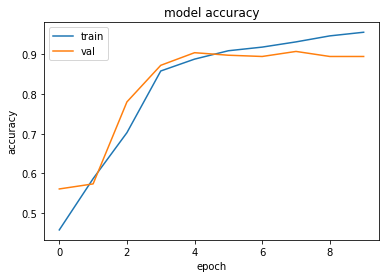

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

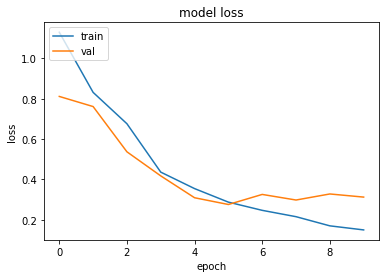

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Get predictions
y_pred = model.predict(X_test)

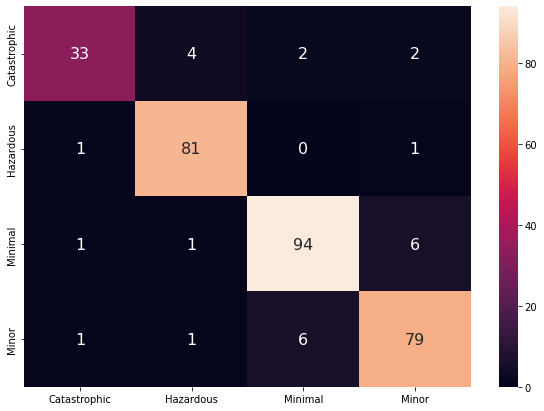

In [ ]:
# Plot confusion matrix 
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

33 Catastrophic labels were predicted correctly, while 4 were predicted as Hazardous,2 as Minimal and 2 as Minor.

81 Hazardous labels were predicted correctly, while 1 were predicted as Catastrophic, 0 as Minimal and 1 as Minor.

94 Minimal labels were predicted correctly, while 1 were predicted as Catastrophic,1 as Hazardous and 6 as Minor.

79 Minor labels were predicted correctly, while 1 were predicted as Catastrophic,1 as Hazardous and 6 as Minimal.


In [ ]:
classReport = metrics.classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.92      0.80      0.86        41
   Hazardous       0.93      0.98      0.95        83
     Minimal       0.92      0.92      0.92       102
       Minor       0.90      0.91      0.90        87

    accuracy                           0.92       313
   macro avg       0.92      0.90      0.91       313
weighted avg       0.92      0.92      0.92       313



### ROC curve

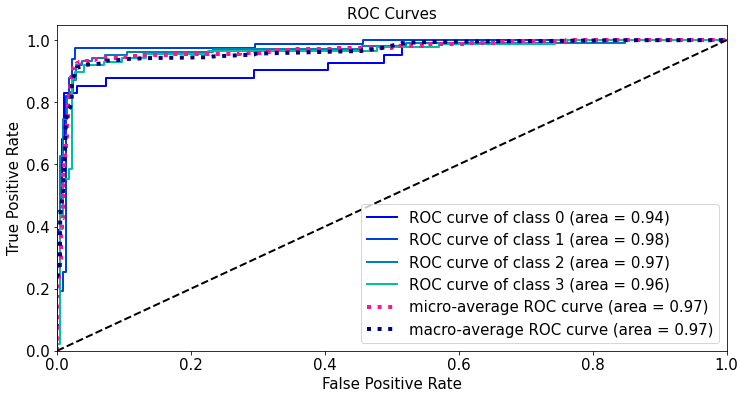

In [ ]:
skplt.metrics.plot_roc(Y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above ROC curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor            

### Precision-Recall curve

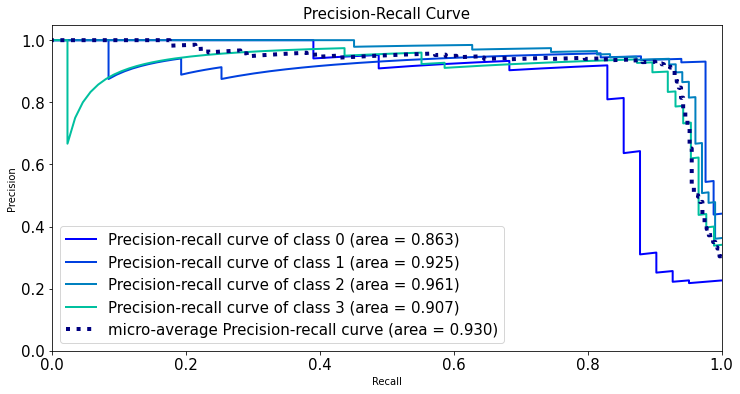

In [ ]:
skplt.metrics.plot_precision_recall_curve(Y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above Precision-Recall curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor 

### CNN with word embeddings

In [ ]:
# Read the data
df_cnn = pd.read_csv('/content/drive/MyDrive/Yinky_DL_FINAL__9521/data/test.csv')

print(df_cnn.shape)

(3132, 3)


In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_cnn['preprocessed2'].values)
X = tokenizer.texts_to_sequences(df_cnn['preprocessed2'].values)

vocab_size = len(tokenizer.word_index) + 1
max_len = max([len(x) for x in X])
print(f'Max length: {max_len}')
# Pad sequneces
X = pad_sequences(X, padding='post', maxlen=max_len)
Y = df_cnn['Classification']

Max length: 46


In [ ]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify=Y)
# Added code
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size = 0.5, random_state = 42,stratify=Y_test)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(2505, 46) (2505,)
(314, 46) (314,)
(313, 46) (313,)


In [ ]:
# Encode the labels
lb1 = LabelBinarizer()
lb1.fit(Y_train)
Y_train = lb1.transform(Y_train)
Y_val = lb1.transform(Y_val)
Y_test = lb1.transform(Y_test)

In [ ]:
lb1.classes_

array(['Catastrophic', 'Hazardous', 'Minimal', 'Minor'], dtype='<U12')

### Build CNN model with word embedding

In [ ]:
from keras.layers import Embedding, Flatten, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, 300, input_length=max_len))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))     # filters tried - 32, 64, kernel_size tried - 8, 3
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))   # number of units tried - 10, 64
cnn_model.add(Dropout(0.5))            # Dropout rate tried - 0.4, 0.5, 0.6
cnn_model.add(Dense(len(lb1.classes_), activation='softmax'))
cnn_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics = ['accuracy'])
print(cnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 46, 300)           728700    
_________________________________________________________________
conv1d (Conv1D)              (None, 44, 64)            57664     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                90176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [ ]:
batch_size = 64    # batch_size tried - 32, 64
# Added validation_data parameter
history = cnn_model.fit(X_train, Y_train, epochs = 30, batch_size=batch_size, validation_data = (X_val, Y_val)) # epochs tried - 10, 20, 40, 150, 100

Epoch 1/30
40/40 [==============================] - 28s 18ms/step - loss: 1.3575 - accuracy: 0.3361 - val_loss: 1.3330 - val_accuracy: 0.3631
Epoch 2/30
40/40 [==============================] - 0s 9ms/step - loss: 1.3119 - accuracy: 0.3900 - val_loss: 1.2886 - val_accuracy: 0.4490
Epoch 3/30
40/40 [==============================] - 0s 8ms/step - loss: 1.2662 - accuracy: 0.4459 - val_loss: 1.2369 - val_accuracy: 0.4777
Epoch 4/30
40/40 [==============================] - 0s 8ms/step - loss: 1.1991 - accuracy: 0.4862 - val_loss: 1.1648 - val_accuracy: 0.5223
Epoch 5/30
40/40 [==============================] - 0s 8ms/step - loss: 1.1160 - accuracy: 0.5234 - val_loss: 1.0719 - val_accuracy: 0.5414
Epoch 6/30
40/40 [==============================] - 0s 8ms/step - loss: 1.0385 - accuracy: 0.5557 - val_loss: 0.9835 - val_accuracy: 0.5796
Epoch 7/30
40/40 [==============================] - 0s 8ms/step - loss: 0.9525 - accuracy: 0.5776 - val_loss: 0.9023 - val_accuracy: 0.6083
Epoch 8/30
40/40 [

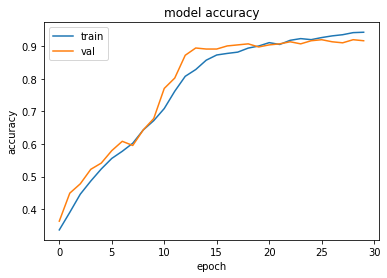

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

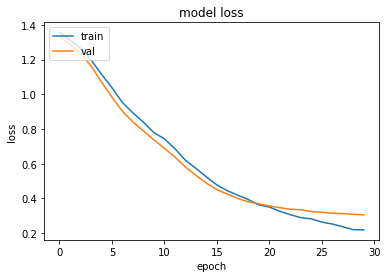

In [ ]:
# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Get predictions
y_pred = cnn_model.predict(X_test)

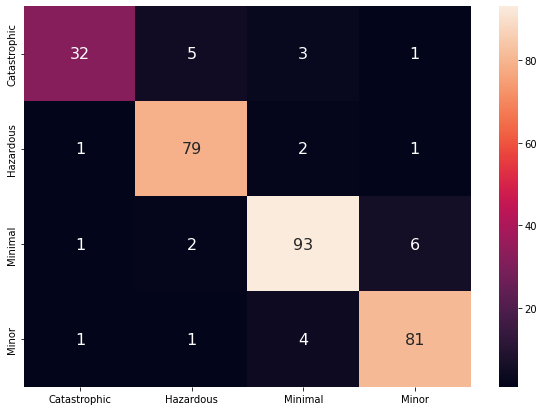

In [ ]:
# Plot confusion matrix
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

32 Catastrophic labels were predicted correctly, while 5 were predicted as Hazardous,3 as Minimal and 1 as Minor.

79 Hazardous labels were predicted correctly, while 1 were predicted as Catastrophic, 2 as Minimal and 1 as Minor.

93 Minimal labels were predicted correctly, while 1 were predicted as Catastrophic,2 as Hazardous and 6 as Minor.

81 Minor labels were predicted correctly, while 1 were predicted as Catastrophic,1 as Hazardous and 4 as Minimal.

In [ ]:
classReport = metrics.classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.91      0.78      0.84        41
   Hazardous       0.91      0.95      0.93        83
     Minimal       0.91      0.91      0.91       102
       Minor       0.91      0.93      0.92        87

    accuracy                           0.91       313
   macro avg       0.91      0.89      0.90       313
weighted avg       0.91      0.91      0.91       313



### ROC curve

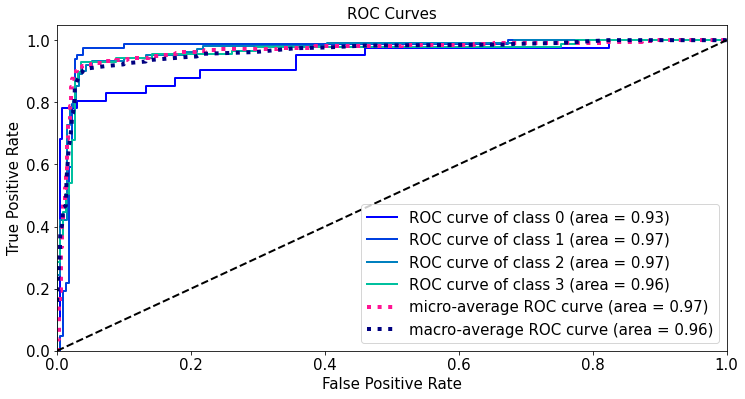

In [ ]:
skplt.metrics.plot_roc(Y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above ROC curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor

### Precision-Recall curve

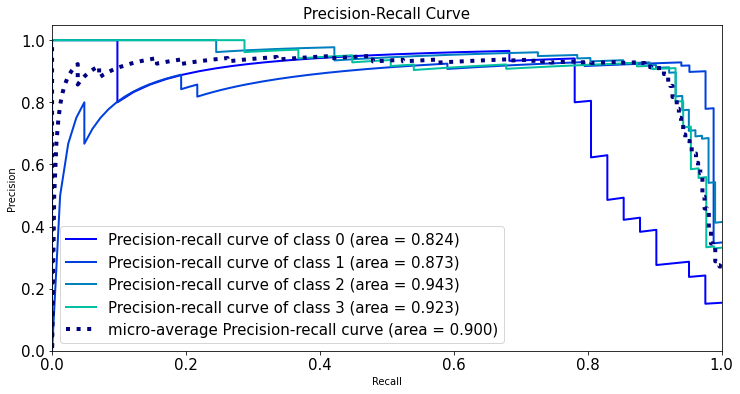

In [ ]:
skplt.metrics.plot_precision_recall_curve(Y_test.argmax(axis=1), y_pred, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

In above Precision-Recall curve,  
class 0 -  Catastrophic        
class 1 -  Hazardous      
class 2 -  Minimal           
class 3 -  Minor 